### Gas Pumps Use Case Simulation

#### This simulation reproduces the fuel sales scenario for 2022 in Brazil. In the scenario, the gas pumps and the fleet of vehicles in circulation are replicated, and the refueling is recreated, totaling the volume of fuel sold in that year. A deficit factor (poisson) is also inserted in the gas pumps that represent volumetric fraud. The objective of this is to evaluate and validate the fraud detection model proposed in the article.

# Library Imports

In [159]:
from scipy.stats import skewnorm, norm
from random import random, randint
import matplotlib.pyplot as plt
import numpy
import csv
import pandas as pd
import json
import time
import math
import tracemalloc

# Scenario parameters definition

In [197]:
scenario_fragment = 1 # percentage of the scenario used in the simulation, 1 represents the total scenario
time_fragment = 1 # fraction of time used in the simulation, 1 represents one year
adoption = 0.01 # fraction of adoption, 1 means that all users submitted data

meanDeficit = 3 # percentage value of deficit from the average volume of gas pumps (Volumetric duel deficit)
peakShortfall = 10 # percentage value of deficit from the average volume of fraudulent gas pumps (Fraudulent gas pump shortfall)
tolerance = 0.5 # percentage value of tolerance, used as maximum negative deficit
peakShortfallVariation = 2 # percentage value of variation from the peak
efficiencyRange = 20 # percentage value of variation in vehicle efficiency

biasedVehiclesFault = 10 # percentage value of users who forget to submit data
biasedFault = 10 # percentage of times that forgetful users forget to submit data
biasedVehiclesManipulation = 5 # percentage value of users who manipulate the data
efficiencyBias = 20 # percentage value of data manipulation by users who manipulate the data

# when changing this parameter you do not need to run everything again, just the evaluation
positivity = 100 # percentage of positivity in relation to the estimate of fraudulent gas pumps

# Constants definition


In [198]:
# Simulation parameters, data for the year 2022

totalNumberOfGasPumpsByFuel = {
    'gasoline': 187299,
    'ethanol': 65155,
    'diesel': 266737
}

numbersByProfile = {
    'automobilesWithGasoline': {
        'vehicles': 46587851,
        'efficiency': 14.1,
        'tank': 50,
        'fuel': 33912375910 * (1 + meanDeficit/100), # fraud correction
        'refuelings': 1397189887 # with fraud correction
    },
    'automobilesWithEthanol': {
        'vehicles': 14615548,
        'efficiency': 10.3,
        'tank': 50,
        'fuel': 14564063109 * (1 + meanDeficit / 100),  # fraud correction
        'refuelings': 582562524  # with fraud correction
    },
    'automobilesWithDiesel': {
        'vehicles': 1896942,
        'efficiency': 12.3,
        'tank': 55,
        'fuel': 3177622640 * (1 + meanDeficit / 100),  # fraud correction
        'refuelings': 119016411
    },
    'lightCommercialGasoline': {
        'vehicles': 4002530,
        'efficiency': 13.2,
        'tank': 55,
        'fuel': 3112183992 * (1 + meanDeficit / 100),  # fraud correction
        'refuelings': 116565436  # with fraud correction
    },
    'lightCommercialEthanol': {
        'vehicles': 1302644,
        'efficiency': 9.4,
        'tank': 55,
        'fuel': 1422336890 * (1 + meanDeficit / 100),  # fraud correction
        'refuelings': 51721341  # with fraud correction
    },
    'lightCommercialDiesel': {
        'vehicles': 439711,
        'efficiency': 12.1,
        'tank': 55,
        'fuel': 8411424655 * (1 + meanDeficit / 100),  # fraud correction
        'refuelings': 315046087  # with fraud correction
    },
    'truckWithDiesel': {
        'vehicles': 3732698,
        'efficiency': 1.56,
        'tank': 495,
        'fuel': 49300539870 * (1 + meanDeficit / 100),  # fraud correction
        'refuelings': 205169923  # with fraud correction
    },
    'busWithDiesel': {
        'vehicles': 729830,
        'efficiency': 3.3,
        'tank': 300,
        'fuel': 4556812833 * (1 + meanDeficit / 100),  # fraud correction
        'refuelings': 31290114  # with fraud correction
    },
    'motorcycleWithGasoline': {
        'vehicles': 30455479,
        'efficiency': 35,
        'tank': 16.1,
        'fuel': 8931040097 * (1 + meanDeficit / 100),  # fraud correction
        'refuelings': 1142729354  # with fraud correction
    }
}

In [199]:
# Expected cross-parameters
numbersExpectByProfile = {
    'automobilesWithGasoline': {
        'mileage': 478164500336, # based on original fuel, without fraud correction
        'mileageByVehicle': 10263.72, # based on original fuel, without fraud correction
        'refuelings': 1397189887, # with fraud correction
        'refuelingsByVehicle': 29.99, # with fraud correction
        'refueledVolume': 34929747187, # with fraud correction
        'refueledVolumeByVehicle': 34929747187 / 46587851, # with fraud correction
        'volumeByRefueling': 25 # without fraud correction
    },
    'automobilesWithEthanol': {
        'mileage': 150009850029,
        'mileageByVehicle': 10263.72,
        'refuelings': 582562524,
        'refuelingsByVehicle': 39.86,
        'refueledVolume': 14564063109,
        'refueledVolumeByVehicle': 14564063109 / 14615548,
        'volumeByRefueling': 25
    },
    'automobilesWithDiesel': {
        'mileage': 39084758478,
        'mileageByVehicle': 20604.09,
        'refuelings': 119016411,
        'refuelingsByVehicle': 62.74,
        'refueledVolume': 3272951319,
        'refueledVolumeByVehicle': 3272951319 / 1896942,
        'volumeByRefueling': 27.50
    },
    'lightCommercialGasoline': {
        'mileage': 41080828696,
        'mileageByVehicle': 10263.72,
        'refuelings': 116565436,
        'refuelingsByVehicle': 29.12,
        'refueledVolume': 3205549511,
        'refueledVolumeByVehicle': 3205549511 / 4002530,
        'volumeByRefueling': 27.50
    },
    'lightCommercialEthanol': {
        'mileage': 13369966769,
        'mileageByVehicle': 10263.72,
        'refuelings': 51721341,
        'refuelingsByVehicle': 39.70,
        'refueledVolume': 1422336890,
        'refueledVolumeByVehicle':1422336890 / 1302644,
        'volumeByRefueling': 27.50
    },
    'lightCommercialDiesel': {
        'mileage': 101778238330,
        'mileageByVehicle': 20604.09,
        'refuelings': 315046087,
        'refuelingsByVehicle': 63.78,
        'refueledVolume': 8663767395,
        'refueledVolumeByVehicle': 8663767395 / 4939711,
        'volumeByRefueling': 27.50
    },
    'truckWithDiesel': {
        'mileage': 76908842197,
        'mileageByVehicle': 20604.09,
        'refuelings': 205169923,
        'refuelingsByVehicle': 54.97,
        'refueledVolume': 50779556066,
        'refueledVolumeByVehicle': 50779556066 / 3732698,
        'volumeByRefueling': 247.50
    },
    'busWithDiesel': {
        'mileage': 15037482352,
        'mileageByVehicle': 20604.09,
        'refuelings': 31290114,
        'refuelingsByVehicle': 42.87,
        'refueledVolume': 4693517219,
        'refueledVolumeByVehicle': 4693517219 / 729830,
        'volumeByRefueling': 150
    },
    'motorcycleWithGasoline': {
        'mileage': 312586403411,
        'mileageByVehicle': 10263.72,
        'refuelings': 1142729354,
        'refuelingsByVehicle': 37.52,
        'refueledVolume': 9198971300,
        'refueledVolumeByVehicle': 9198971300 / 30455479,
        'volumeByRefueling': 8.05
    }
}

In [200]:
# Mapping profiles to fuel type
fuel_type_by_profile = {
    'automobilesWithGasoline': 'gasoline',
    'automobilesWithEthanol': 'ethanol',
    'automobilesWithDiesel': 'diesel',
    'lightCommercialGasoline': 'gasoline',
    'lightCommercialEthanol': 'ethanol',
    'lightCommercialDiesel': 'diesel',
    'truckWithDiesel': 'diesel',
    'busWithDiesel': 'diesel',
    'motorcycleWithGasoline': 'gasoline'
}

profile_names = [
    'automobilesWithGasoline'
    , 'automobilesWithEthanol', 'automobilesWithDiesel', 'lightCommercialGasoline', 'lightCommercialEthanol', 'lightCommercialDiesel', 'truckWithDiesel','busWithDiesel', 'motorcycleWithGasoline'
]

In [201]:
# Relative parameters, proportion (percentage) relative to the total data

gasPumpsByFuel = totalNumberOfGasPumpsByFuel.copy()
for fuel_type in ['gasoline', 'ethanol', 'diesel']:
    gasPumpsByFuel[fuel_type] = int(round(gasPumpsByFuel[fuel_type] * scenario_fragment, 0))

profiles = {}
for profile_name in profile_names:
    profiles[profile_name] = numbersByProfile[profile_name].copy()
    profiles[profile_name]['vehicles'] = int(round(profiles[profile_name]['vehicles'] * scenario_fragment * adoption, 0))
    profiles[profile_name]['fuel'] = profiles[profile_name]['fuel'] * scenario_fragment * time_fragment * adoption
    profiles[profile_name]['refuelings'] = profiles[profile_name]['refuelings'] * scenario_fragment * time_fragment * adoption

expectByProfile = {}
for profile_name in profile_names:
    expectByProfile[profile_name] = numbersExpectByProfile[profile_name].copy()
    expectByProfile[profile_name]['mileage'] = expectByProfile[profile_name]['mileage'] * scenario_fragment * time_fragment * adoption
    expectByProfile[profile_name]['mileageByVehicle'] = expectByProfile[profile_name]['mileage'] / profiles[profile_name]['vehicles']
    expectByProfile[profile_name]['refuelings'] = expectByProfile[profile_name]['refuelings'] * scenario_fragment * time_fragment * adoption
    expectByProfile[profile_name]['refuelingsByVehicle'] = expectByProfile[profile_name]['refuelings'] / profiles[profile_name]['vehicles']
    expectByProfile[profile_name]['refueledVolume'] = profiles[profile_name]['fuel']
    expectByProfile[profile_name]['refueledVolumeByVehicle'] = profiles[profile_name]['fuel'] / profiles[profile_name]['vehicles']


In [202]:
# Obs.: Due to rounding at gas pumps and vehicles, the numbers may differ slightly from the reference table.
print('Number of gas pumps:', json.dumps(gasPumpsByFuel, sort_keys=True, indent=4))
print("----------")
print('Profiles:', json.dumps(profiles, sort_keys=True, indent=4))
print("----------")
print('Expected numbers:', json.dumps(expectByProfile, sort_keys=True, indent=4))

Number of gas pumps: {
    "diesel": 266737,
    "ethanol": 65155,
    "gasoline": 187299
}
----------
Profiles: {
    "automobilesWithDiesel": {
        "efficiency": 12.3,
        "fuel": 32729513.192000005,
        "refuelings": 1190164.11,
        "tank": 55,
        "vehicles": 18969
    },
    "automobilesWithEthanol": {
        "efficiency": 10.3,
        "fuel": 150009850.0227,
        "refuelings": 5825625.24,
        "tank": 50,
        "vehicles": 146155
    },
    "automobilesWithGasoline": {
        "efficiency": 14.1,
        "fuel": 349297471.873,
        "refuelings": 13971898.870000001,
        "tank": 50,
        "vehicles": 465879
    },
    "busWithDiesel": {
        "efficiency": 3.3,
        "fuel": 46935172.1799,
        "refuelings": 312901.14,
        "tank": 300,
        "vehicles": 7298
    },
    "lightCommercialDiesel": {
        "efficiency": 12.1,
        "fuel": 86637673.9465,
        "refuelings": 3150460.87,
        "tank": 55,
        "vehicles": 4397

# Auxiliary Functions

In [166]:
# Function to generate displaced normal curve

def skewedDistribution(a, mean, size, min_value=None, max_value=None):

  # a: Curve shift parameter (positive shifts the peak to the left, negative shifts the peak to the right).
  # The a is used to achieve the desired mean.
  # minValue: Minimum desired value
  # maxValue: Maximum desired value
  # n: Number of desired samples
  # Returns a list with the distribution

  if min_value is not None and max_value is not None:
    scale = ((max_value-min_value) / 5) # empirical number to fit the scale
    data = skewnorm.rvs(a, loc=1, scale=scale, size=size)
    data[(data < min_value) | (data > max_value)] = mean
  else:
    data = skewnorm.rvs(a, loc=1, scale=a, size=size)

  return data

In [167]:
# Function to generate normal distribution

def normalDistribution(mean, size, min_value=None, max_value=None, std=1, defaultValue=None):

  # mean: Mean of the normal curve
  # minValue: Minimum desired value
  # maxValue: Maximum desired value
  # size: Number of desired samples
  # Returns a list with the distribution

  if min_value is not None and max_value is not None:
    #scale = ((max_value-min_value) / 8) # empirical number to fit the scale
    data = norm.rvs(mean, size=size, scale=std)
    data[(data < min_value) | (data > max_value)] = defaultValue or mean
  else:
    data = norm.rvs(mean, size=size, scale=std)

  return data

In [168]:
# Function to generate a distribution with two peaks

def twoPeaksDistribution(first, second, range1, range2, size, mean, std1=1, std2=1):

  # first: Average of the first peak of the curve
  # second: Average of the second peak of the curve
  # mean: Average of the samples
  # n: desired number of samples
  # Returns a list with the distribution

  # Calculate n of first peak using the formula for weighted average
  n1 = ((size * mean) - (second * size)) / (first - second)

  # Generate two sets of samples from normal distributions
  data1 = normalDistribution(mean=first, min_value=first-range1, max_value=first+range1, size=round(n1), std=std1)
  data2 = normalDistribution(mean=second, min_value=second-range2, max_value=second+range2, size=round(size-n1), std=std2)

  # Combine the two distributions
  data = numpy.concatenate((data1, data2))

  return data

In [169]:
# Funtion to plot a histogram of a distribution

def plotHistDistribution(distribution, label, bins=100):
  plt.hist(distribution, bins = bins)
  plt.title(label)
  plt.show()
  print('Mean:', sum(distribution)/len(distribution))
  print('Std:', numpy.std(distribution))
  print('Min:', min(distribution))
  print('Max:', max(distribution))

In [170]:
# Function to plot a bar graph of a distribution

def plotBarDistribution(x, y, label):
  plt.bar(x, y)
  plt.title(label)
  plt.show()
  print('Mean:', sum(y)/len(y))
  print('Min:', min(y))
  print('Max:', max(y))

In [171]:
# Remove outliers com o método de Tukey

def removeOutliers(df_tuple):

  df = pd.DataFrame(df_tuple.values(), columns=['value'])
  Q3 = df['value'].quantile(0.75)
  Q1 = df['value'].quantile(0.25)

  IQR = Q3 - Q1

  min_value = Q1 - (IQR * 1.5)
  max_value = Q3 + (IQR * 1.5)

  outliers = {}
  new_df = {}
  for row in df_tuple:
    if df_tuple[row] < min_value or df_tuple[row] > max_value:
      outliers[row] = df_tuple[row]
    else:
      new_df[row] = df_tuple[row]
  return outliers, new_df


# Creating Tables Functions

In [172]:
# Gas pumps table
#
# Attributes: list with deficits indexed by gas pump id
#

def generateGasPumps(nGasPumps, deficit, mean):

  deficit = twoPeaksDistribution(first=1, second=deficit, range1=tolerance/100, range2=peakShortfallVariation/100, size=nGasPumps, mean=mean, std1=0.002, std2=0.01)

  return deficit


In [173]:
# Vehicles table
#
# Attributes: matrix with odometer indexed by vehicle id
#

def generateVehiclesList(profile):
  vehiclesOdometerList = []
  for i in range(profile['vehicles']):
      vehiclesOdometerList.append(0)

  return vehiclesOdometerList


In [174]:
# Refuelings Table
#
# Attributes: list of refuelings per vehicle with volume and fk_gas_pump
#

def generateRefuelingTable(profile, fuelType, gasPumpsDeficitList, vehiclesOdometerList, biasedVehiclesFault=0, biasedVehiclesManipulation=0, biasedFault=0, efficiencyBias=0):
    refuelingCount = 0
    refuelingsGasPumpList = []
    refuelingsVolumeList = []

    estimatedRefuelingCount = round(profile['refuelings'])
    vehiclesCount = profile['vehicles']
    refuelingsVehicles = (estimatedRefuelingCount / vehiclesCount)
    tank = profile['tank']
    efficiency = profile['efficiency']
    efficiencyRangeAdjusted = efficiency * (efficiencyRange / 100)
    refuelingCountBiasedFault = math.ceil(estimatedRefuelingCount * (biasedVehiclesFault/100))
    refuelingCountBiasedDeficit = math.ceil(estimatedRefuelingCount * (biasedVehiclesManipulation/100))
    vehicleCountBiasedFault = math.floor(vehiclesCount * (biasedVehiclesFault/100))
    vehicleCountBiasedDeficit = math.floor(vehiclesCount * (biasedVehiclesManipulation/100)) + vehicleCountBiasedFault

    seedsVehicle = normalDistribution(mean=refuelingsVehicles, size=vehiclesCount, min_value=0, max_value=refuelingsVehicles*2, std=12)
    seedsGasPump = numpy.random.randint(gasPumpsByFuel[fuelType], size=estimatedRefuelingCount)
    seedsRefuelingFuel = normalDistribution(mean=tank/2, size=estimatedRefuelingCount, min_value=0, max_value=tank, std=7)
    seedsConsumedFuel = normalDistribution(mean=0.5, size=estimatedRefuelingCount, min_value=0, max_value=1, std=0.15)
    seedsRefuelingEfficiency = normalDistribution(mean=efficiency, size=estimatedRefuelingCount, min_value=efficiency-efficiencyRangeAdjusted, max_value=efficiency+efficiencyRangeAdjusted, std=0.85)
    seedsRefuelingFault = numpy.random.choice([1, 0], size=math.ceil(refuelingCountBiasedFault*1.3), p=[1-biasedFault/100, biasedFault/100])
    seedsRefuelingDeficit = twoPeaksDistribution(mean=1, size=math.ceil(refuelingCountBiasedDeficit*1.3), first=0.8, second=1.2, range1=0.2, range2=0.2)

    #plotHistDistribution(seedsConsumedFuel, 'seedsConsumedFuel')

    refuelingEfficiencyList = []

    for vehicleId, numRefuelings in enumerate(seedsVehicle):

      dynamicConsumption = efficiency
      fuel = 0
      odometer = 0
      refuelingsGasPumpList.append([])
      refuelingsVolumeList.append([])

      # Loop until either all suplies for vehicle or number of refueled exceeds total
      for i in range(round(numRefuelings)):

          if refuelingCount == estimatedRefuelingCount:
            break

          gasPumpId = seedsGasPump[refuelingCount]
          refuelingFuel = seedsRefuelingFuel[refuelingCount]

          minimalConsumption = fuel + refuelingFuel - tank
          if minimalConsumption < 0:
            minimalConsumption = 0

          consumedFuel = seedsConsumedFuel[refuelingCount] * (fuel - minimalConsumption) + minimalConsumption

          # Calculate Km driven with the consumed fuel and dynamic Consumption
          odometer += (consumedFuel * dynamicConsumption)

          # Calculate the refueling fuel amount and the new dynamic consumption for next refueling

          refuelingEfficiency = seedsRefuelingEfficiency[refuelingCount] * gasPumpsDeficitList[gasPumpId]

          remainingFuel = fuel - consumedFuel

          # Calculate new dynamyc consumption
          dynamicConsumption = ((dynamicConsumption * remainingFuel) + (refuelingEfficiency * refuelingFuel)) / (remainingFuel + refuelingFuel)

          fuel = remainingFuel + refuelingFuel

          if vehicleId < vehicleCountBiasedFault: # forgotten users
            if seedsRefuelingFault[refuelingCount]:
              refuelingsGasPumpList[vehicleId].append(gasPumpId)
              refuelingsVolumeList[vehicleId].append(refuelingFuel)
              vehiclesOdometerList[vehicleId] = odometer
          elif vehicleId < vehicleCountBiasedDeficit: # users who manipulate
            refuelingsGasPumpList[vehicleId].append(gasPumpId)
            refuelingsVolumeList[vehicleId].append(refuelingFuel)
            vehiclesOdometerList[vehicleId] = odometer*seedsRefuelingDeficit[refuelingCount-refuelingCountBiasedFault]
          else: # normal users
            refuelingsGasPumpList[vehicleId].append(gasPumpId)
            refuelingsVolumeList[vehicleId].append(refuelingFuel)
            vehiclesOdometerList[vehicleId] = odometer
          refuelingCount += 1

    return {'refuelingsGasPumpList': refuelingsGasPumpList, 'refuelingsVolumeList': refuelingsVolumeList}


# Verifications Functions

Numbers obtained vs. expected

In [175]:
def crossParametersCheck(fuel_type, vehiclesOdometerList, refuelings):
    refuelingsVolumeList = refuelings['refuelingsVolumeList']
    refuelingsGasPumpList = refuelings['refuelingsGasPumpList']

    print(f'\n== Verifications for {fuel_type} ==\n')

    totalMileage = sum(vehiclesOdometerList)
    totalRefuelings = sum(len(refuelingList) for refuelingList in refuelingsGasPumpList)
    totalVolume = sum(sum(volumeList) for volumeList in refuelingsVolumeList)

    totalVehicles = len(vehiclesOdometerList)
    mileageByVehicle = totalMileage / totalVehicles
    refueledVolumeByVehicle = totalVolume / totalVehicles
    refuelingsByVehicle = totalrefuelings / totalVehicles
    volumeByRefueling = totalVolume / totalrefuelings if totalrefuelings > 0 else 0

    expectedMileage = sum(expectByProfile[profile]['mileage'] for profile in expectByProfile if fuel_type_by_profile[profile] == fuel_type)
    expectedRefueledVolume = sum(expectByProfile[profile]['refueledVolume'] for profile in expectByProfile if fuel_type_by_profile[profile] == fuel_type)
    expectedRefuelings = sum(expectByProfile[profile]['refuelings'] for profile in expectByProfile if fuel_type_by_profile[profile] == fuel_type)

    print('Total mileage:', totalMileage)
    print('Total mileage expected:', expectedMileage)
    print('Total achieved of expected: %.2f%%' % (totalMileage * 100 / expectedMileage))

    print('\nMileage by vehicle:', mileageByVehicle)
    print('Mileage expected by vehicle:', expectedMileage / totalVehicles)
    print('Total achieved of expected: %.2f%%' % (mileageByVehicle * 100 / (expectedMileage / totalVehicles)))

    print('\nTotal refueled volume:', totalVolume)
    print('Total refueled volume expected:', expectedRefueledVolume)
    print('Total achieved of expected: %.2f%%' % (totalVolume * 100 / expectedRefueledVolume))

    print('\nRefueled volume by vehicle:', refueledVolumeByVehicle)
    print('Refueled volume expected by vehicle:', expectedRefueledVolume / totalVehicles)
    print('Total achieved of expected: %.2f%%' % (refueledVolumeByVehicle * 100 / (expectedRefueledVolume / totalVehicles)))

    print('\nTotal refuelings:', totalRefuelings)
    print('Total refuelings expected:', expectedRefuelings)
    print('Total achieved of expected: %.2f%%' % (totalRefuelings * 100 / expectedRefuelings))

    print('\nRefuelings by vehicle:', refuelingsByVehicle)
    print('Refuelings expected by vehicle:', expectedRefuelings / totalVehicles)
    print('Total achieved of expected: %.2f%%' % (refuelingsByVehicle * 100 / (expectedRefuelings / totalVehicles)))

    print('\nVolume by refueling:', volumeByRefueling)
    print('Volume expected by refueling:', expectedRefueledVolume / expectedRefuelings)
    print('Total achieved of expected: %.2f%%' % (volumeByRefueling * 100 / (expectedRefueledVolume / expectedRefuelings)))

In [176]:
def crossParametersCheckByProfile(profile_name, vehiclesOdometerList, refuelings):
    refuelingsVolumeList = refuelings['refuelingsVolumeList']
    refuelingsGasPumpList = refuelings['refuelingsGasPumpList']

    print(f'\n== Verificações para {profile_name} ==\n')
    print('Total mileage:', sum(vehiclesOdometerList))
    print('Total mileage expected:', expectByProfile[profile_name]['mileage'])
    print('Total achieved of expected: %.2f%%' % (sum(vehiclesOdometerList) * 100 / expectByProfile[profile_name]['mileage']))
    print('Obs.: the difference here is because of the fuel remaining in the vehicles tanks at the end.')

    print('\nMileage by vehicle:', sum(vehiclesOdometerList) / profiles[profile_name]['vehicles'])
    print('Mileage expected by vehicle:', expectByProfile[profile_name]['mileageByVehicle'])
    print('Total achieved of expected: %.2f%%' % (sum(vehiclesOdometerList) / profiles[profile_name]['vehicles'] * 100 / expectByProfile[profile_name]['mileageByVehicle']))

    totalVolume = sum(sum(volumeList) for volumeList in refuelingsVolumeList)
    print('\nTotal refueled volume:', totalVolume)
    print('Total refueled volume expected:', expectByProfile[profile_name]['refueledVolume'])
    print('Total achieved of expected: %.2f%%' % (totalVolume * 100 / expectByProfile[profile_name]['refueledVolume']))

    print('\nRefueled volume by vehicle:', totalVolume / profiles[profile_name]['vehicles'])
    print('Refueled volume expected by vehicle:', expectByProfile[profile_name]['refueledVolumeByVehicle'])
    print('Total achieved of expected: %.2f%%' % (totalVolume / profiles[profile_name]['vehicles'] * 100 / expectByProfile[profile_name]['refueledVolumeByVehicle']))

    totalRefuelings = sum(len(refuelingList) for refuelingList in refuelingsGasPumpList)
    print('\nTotal refuelings:', totalRefuelings)
    print('Total refuelings expected:', expectByProfile[profile_name]['refuelings'])
    print('Total achieved of expected: %.2f%%' % (totalRefuelings * 100 / expectByProfile[profile_name]['refuelings']))

    print('\nRefuelings by vehicle:', totalRefuelings / profiles[profile_name]['vehicles'])
    print('Refuelings expected by vehicle:', expectByProfile[profile_name]['refuelingsByVehicle'])
    print('Total achieved of expected: %.2f%%' % (totalRefuelings / profiles[profile_name]['vehicles'] * 100 / expectByProfile[profile_name]['refuelingsByVehicle']))

    print('\nVolume by refueling:', totalVolume / totalRefuelings if totalRefuelings > 0 else 0)
    print('Volume expect by refueling:', expectByProfile[profile_name]['volumeByRefueling'])
    print('Total achieved of expected: %.2f%%' % (totalVolume / totalRefuelings * 100 / expectByProfile[profile_name]['volumeByRefueling'] if totalRefuelings > 0 else 0))


Distributions

In [177]:

def plotDistributions(gasPumpsDeficitList, refuelings):
  refuelingsVolumeList = refuelings['refuelingsVolumeList']
  refuelingsGasPumpList = refuelings['refuelingsGasPumpList']

  print('\n== Distributions ==\n')

  # Frauds
  plotHistDistribution(gasPumpsDeficitList, 'Percentage of Deficits from gas pumps', bins=100)

  # Refuelings by vehicle
  refuelingsVehicle = [len(i) for i in refuelingsGasPumpList]
  plotHistDistribution(refuelingsVehicle, 'Frequency of vehicles by quantity of refuelings')

  # Refuelings by gas pump
  refuelingsGasPump = [0  for i in range(len(gasPumpsDeficitList))]
  for i in range(len(refuelingsGasPumpList)):
    for j in range(len(refuelingsGasPumpList[i])):
      refuelingsGasPump[refuelingsGasPumpList[i][j]] += 1
  #plotBarDistribution(df_refuelings.groupby('fk_gas_pump').count().fuel.index, df_refuelings.groupby('fk_gas_pump').count().fuel, 'Refuelings quantity per gas pump')
  plotHistDistribution(refuelingsGasPump, 'Frequency of gas pumps by refueling quantity')

  # Volume by refueling
  refuelingsVolume = []
  for i in range(len(refuelingsVolumeList)):
    refuelingsVolume += refuelingsVolumeList[i]
  plotHistDistribution(refuelingsVolume, 'Frequency of refuelings by volume')

# Summary Functions

Gas pumps summary

In [178]:

def resumeGasPumps(gasPumpsByType):
  total = 0
  deficit = []
  print('Gas pumps by fuel type:')
  for k in gasPumpsByType:
    print(' -', k, ':', len(gasPumpsByType[k]))
    print('   - Deficit:')
    print('     - average: ', sum(gasPumpsByType[k]) / len(gasPumpsByType[k]))
    print('     - max: ', max(gasPumpsByType[k]))
    print('     - min: ', min(gasPumpsByType[k]))
    total += len(gasPumpsByType[k])
    deficit += list(gasPumpsByType[k])
  print('Total:', total)
  print('\nTotal deficit:')
  print(' - average: ', sum(deficit) / len(deficit))
  print(' - max: ', max(deficit))
  print(' - min: ', min(deficit))

#resumeGasPumps({'gasoline': gasPumpsDeficitList})

Vehicles summary

In [179]:

def resumeVehicle(vehiclesByProfile):
  total = 0
  print('Vehicles by profile:')
  for k in vehiclesByProfile:
    print(' -', k, ':', len(vehiclesByProfile[k]))
    total += len(vehiclesByProfile[k])

  print('Total:', total)

#resumeVehicle({'automobilesWithGasoline': vehiclesOdometerList})

Refuelings

In [180]:
def resumeAbastecimentos(refuelingsByProfile):

  total = 0
  print('Refuelings by profile:')
  for k in refuelingsByProfile:
    totalProfile = 0
    for i in range(len(refuelingsByProfile[k])):
      totalProfile += len(refuelingsByProfile[k][i])
    print(' -', k, ':', totalProfile)
    total += totalProfile

  print('Total:', total)

  '''print('Total de abastecimentos: ', df_refuelings.shape[0])
  print('Volume total dos abastecimentos: ', df_refuelings.fuel.sum())
  print('volume total por tipo de combustível: ')
  print(pd.merge(df_refuelings, df_gas_pump, left_on='fk_gas_pump', right_on='pk_gas_pump').groupby('tipo_combustivel').sum().fuel)
  print('Volume médio por abastecimento: ', df_refuelings.fuel.mean())
  print('Menor volume abastecido: ', df_refuelings.fuel.min())
  print('Maior volume abastecido: ', df_refuelings.fuel.max())
  print('Volume médio por gas pump: ', df_refuelings.fuel.sum()/df_gas_pump.shape[0])
  # print(df_refuelings.groupby('fk_gas_pump')['fuel'].agg(['mean', 'min', 'max']))
  print('Menor n° abastecimentos: ', df_refuelings.groupby('fk_gas_pump').size().min())
  print('Maior n° abastecimentos: ', df_refuelings.groupby('fk_gas_pump').size().max())
  print('Média por gas pump: ', df_refuelings.groupby('fk_gas_pump').size().mean())'''


#resumeAbastecimentos({'automobilesWithGasoline': refuelingsVolumeList})

# Evaluation Functions

In [181]:
def vehiclesEvaluation(refuelings, vehiclesOdometerList, profile):
    refuelingsVolumeList = refuelings['refuelingsVolumeList']
    refuelingsGasPumpList = refuelings['refuelingsGasPumpList']

    vehiclesRating = {}
    for vehicleId in range(len(refuelingsGasPumpList)):
        vehiclesRating[vehicleId] = 1
        if len(refuelingsGasPumpList[vehicleId]) > 1:
            fuelTotal = sum(refuelingsVolumeList[vehicleId]) - refuelingsVolumeList[vehicleId][len(refuelingsVolumeList[vehicleId])-1]
            meanEfficiency = vehiclesOdometerList[vehicleId] / fuelTotal
            vehiclesRating[vehicleId] = meanEfficiency / profile['efficiency']

    return vehiclesRating


In [182]:
def gasPumpsEvaluation(refuelings, gasPumpType, vehiclesRating):

    gasPumpsRating = {}
    gasPumpsTotalVolume = [0 for i in range(gasPumpsByFuel[gasPumpType])]

    for gasPumpId in range(gasPumpsByFuel[gasPumpType]):
      gasPumpsRating[gasPumpId] = 0

    refuelingsVolumeList = refuelings['refuelingsVolumeList']
    refuelingsGasPumpList = refuelings['refuelingsGasPumpList']

    for vehicleId in range(len(refuelingsGasPumpList)):
      if vehicleId in vehiclesRating:
        vehicleRating = vehiclesRating[vehicleId]
        for refuelingId in range(len(refuelingsGasPumpList[vehicleId])):
          gasPumpsRating[refuelingsGasPumpList[vehicleId][refuelingId]] += (vehicleRating * refuelingsVolumeList[vehicleId][refuelingId])
          gasPumpsTotalVolume[refuelingsGasPumpList[vehicleId][refuelingId]] += refuelingsVolumeList[vehicleId][refuelingId]

    for gasPumpId in range(gasPumpsByFuel[gasPumpType]):
      if gasPumpsTotalVolume[gasPumpId] > 0:
        gasPumpsRating[gasPumpId] /= gasPumpsTotalVolume[gasPumpId]

    return gasPumpsRating


In [183]:
def gasPumpsEvaluationGrouped(refuelings, gasPumpType, vehiclesRating):

    gasPumpsRating = {}
    gasPumpsTotalVolume = [0 for i in range(gasPumpsByFuel[gasPumpType])]

    for gasPumpId in range(gasPumpsByFuel[gasPumpType]):
      gasPumpsRating[gasPumpId] = 0

    for profile in range(len(refuelings['refuelingsVolumeList'])):

      refuelingsVolumeList = refuelings['refuelingsVolumeList'][profile]
      refuelingsGasPumpList = refuelings['refuelingsGasPumpList'][profile]

      for vehicleId in range(len(refuelingsGasPumpList)):
        if vehicleId in vehiclesRating[profile]:
          vehicleRating = vehiclesRating[profile][vehicleId]
          for refuelingId in range(len(refuelingsGasPumpList[vehicleId])):
            gasPumpsRating[refuelingsGasPumpList[vehicleId][refuelingId]] += (vehicleRating * refuelingsVolumeList[vehicleId][refuelingId])
            gasPumpsTotalVolume[refuelingsGasPumpList[vehicleId][refuelingId]] += refuelingsVolumeList[vehicleId][refuelingId]

    for gasPumpId in range(gasPumpsByFuel[gasPumpType]):
      if gasPumpsTotalVolume[gasPumpId] > 0:
        gasPumpsRating[gasPumpId] /= gasPumpsTotalVolume[gasPumpId]

    return gasPumpsRating


In [184]:
#vehicles_ordered_ranking = sorted(groupedVehiclesByFuel['gasoline'][0].items(), key=lambda item: item[1])
#print(vehicles_ordered_ranking)

#vehiclesEvaluationPlot = list(list(zip(*vehicles_ordered_ranking))[1])

#plt.plot([1 for i in range(len(vehiclesEvaluationPlot))],vehiclesEvaluationPlot, '.')
#plt.title('Vehicles evaluation')

In [185]:
#gasPumpsEvaluationPlot = list(list(zip(*gasPumps_ordered_ranking))[1])

#plt.plot([1 for i in range(len(gasPumpsEvaluationPlot))],gasPumpsEvaluationPlot, '.')
#plt.title('gasPumps evaluation')

# Confusion Matrix Functions

In [186]:

def generateConfusionMatrixVehiclesAnomaly(estimatedAnomalies, nVehicles, vehiclesOutliers, vehicles, profile_name=None, print_result=False):

  # Estimate the number of anomalies
  estimatedNumberOfAnomalies = math.floor(nVehicles * (estimatedAnomalies/100))
  #print('Number of anomalies:', estimatedNumberOfAnomalies)

  # Gets reference values ​​based on deficit values ​​in the gas pumps table
  truePositivesReference = set(list(range(estimatedNumberOfAnomalies)))
  TPR = len(truePositivesReference)
  trueNegativesReference = set(list(range(estimatedNumberOfAnomalies, nVehicles)))
  TNR = len(trueNegativesReference)

  # Get the positive gas pumps according to the ranking
  positives = set(vehiclesOutliers)
  negatives = set(vehicles)

  # Get the confusion matrix
  truePositives = positives.intersection(truePositivesReference)
  TP = len(truePositives)
  TP_ratio = (TP / TPR * 100) if TPR > 0 else 0

  falseNegatives = negatives.intersection(truePositivesReference)
  FN = len(falseNegatives)
  FN_ratio = (FN / TPR * 100) if TPR > 0 else 0

  trueNegatives = negatives.intersection(trueNegativesReference)
  TN = len(trueNegatives)
  TN_ratio = (TN / TNR * 100) if TNR > 0 else 0

  falsePositives = positives.intersection(trueNegativesReference)
  FP = len(falsePositives)
  FP_ratio = (FP / TNR * 100) if TNR > 0 else 0

  accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
  precision = TP / (TP + FP) if (TP + FP) > 0 else 0


  if print_result:
    print('\n== Outliers confusion matrix (', profile_name ,')==\n')
    print('Number of vehicles:', nVehicles)

    print('\nAnomaly Vehicles:', TPR)
    #print(truePositivesReference)
    print('Non anomaly Vehicles:', TNR)
    #print(trueNegativesReference)

    print('\nPositives:', len(positives))
    #print(positives)
    print('Negatives:', len(negatives))
    #print(negatives)

    print(f'\nTrue Positives (anomalous classified as anomalous): {TP}, ({TP_ratio:.2f}%)')
    #print("\033[32m", truePositives, "\033[0m")
    print(f'False Negatives (anomalous classified as non-anomalous): {FN}, ({FN_ratio:.2f}%)')
    #print("\033[31m", falseNegatives, "\033[0m")
    print(f'True Negatives (non-anomalous classified as non-anomalous): {TN}, ({TN_ratio:.2f}%)')
    #print("\033[32m", trueNegatives, "\033[0m")
    print(f'False Positives (non-anomalous classified as anomalous): {FP}, ({FP_ratio:.2f}%)')
    #print("\033[31m", falsePositives, "\033[0m")
    print('\nAccuracy:', accuracy)
    print('Precision:', precision)

  return {'entities': nVehicles, 'TPR': TPR, 'TNR': TNR, 'positives': len(positives),'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN}


In [187]:

def generateConfusionMatrixGasPumps(estimatedFraudsPercent, gasPumpsDeficitList, ranking, positivity, name, print_result=False):

  nGasPumps = len(gasPumpsDeficitList)

  # Estimate how many gas pumps must be rigged to reach the rigged volume
  estimatedNumberOfFrauds = round(nGasPumps * (estimatedFraudsPercent/100) * (positivity/100))

  # Gets reference values ​​based on deficit values ​​in the gas pumps table
  truePositivesReference = set()
  trueNegativesReference = set()
  for i in range(len(gasPumpsDeficitList)):
    if gasPumpsDeficitList[i] < (1 - tolerance/100):
      truePositivesReference.add(i)
    else:
      trueNegativesReference.add(i)

  TPR = len(truePositivesReference)
  TNR = len(trueNegativesReference)

  # Get the positive gas pumps according to the ranking
  ranking_list = list(list(zip(*ranking))[0])

  positives = set(ranking_list[:estimatedNumberOfFrauds])
  negatives = set(ranking_list[estimatedNumberOfFrauds-nGasPumps:])

  # Get the confusion matrix
  truePositives = positives.intersection(truePositivesReference)
  TP = len(truePositives)

  falseNegatives = negatives.intersection(truePositivesReference)
  FN = len(falseNegatives)

  trueNegatives = negatives.intersection(trueNegativesReference)
  TN = len(trueNegatives)

  falsePositives = positives.intersection(trueNegativesReference)
  FP = len(falsePositives)


  accuracy = (TP + TN) / (TP + TN + FP + FN)
  precision = TP / (TP + FP)

  if print_result:
    print('\n== Gas Pump Fraud Confusion Matrix (', name ,')==\n')
    print('Number of BCMs:', nGasPumps)
    #print('Estimated number of frauds:', estimatedNumberOfFrauds)

    print('Fraudulent gas pumps:', TPR)
    #print(truePositivesReference)
    print('Non fraudulent gas pumps:', TNR)
    #print(trueNegativesReference)

    #print('ranking_list', ranking_list)

    #print('\nPositives:', len(positives))
    #print(positives)
    #print('Negatives:', len(negatives))
    #print(negatives)

    print('True Positives (has fraud and was identified by the system):', TP, '(' + str(TP/TPR * 100) + '%)')
    #print("\033[32m", truePositives, "\033[0m")
    print('False Negatives (has fraud and has not been identified by the system):', FN, '(' + str(FN/TPR * 100) + '%)')
    #print("\033[31m", falseNegatives, "\033[0m")
    print('True Negatives (there is no fraud and it was not identified by the system):', TN, '(' + str(TN/TNR * 100) + '%)')
    #print("\033[32m", trueNegatives, "\033[0m")
    print('False Positives (there is no fraud and it was identified by the system):', FP, '(' + str(FP/TNR * 100) + '%)')
    #print("\033[31m", falsePositives, "\033[0m")

    print('\nAccuracy:', accuracy)
    print('Precision:', precision)

  return {'entities': nGasPumps, 'TPR': TPR, 'TNR': TNR, 'positives': len(positives),'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN}

In [188]:

def joinMatrix(matrixList, label):

  nEntities = 0
  TPR = 0
  TNR = 0
  positives = 0
  TP = 0
  TN = 0
  FP = 0
  FN = 0

  for i in matrixList:
    nEntities += i['entities']
    TPR += i['TPR']
    TNR += i['TNR']
    positives += i['positives']
    TP += i['TP']
    TN += i['TN']
    FP += i['FP']
    FN += i['FN']

  TP_ratio = (TP / TPR * 100) if TPR > 0 else 0
  FN_ratio = (FN / TPR * 100) if TPR > 0 else 0
  TN_ratio = (TN / TNR * 100) if TNR > 0 else 0
  FP_ratio = (FP / TNR * 100) if TNR > 0 else 0

  accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
  precision = TP / (TP + FP) if (TP + FP) > 0 else 0 # div por 0 when no positives

  print('\n== Confusion Matrix:', label, '==')

  print('\nEntities:', nEntities)
  print('TPR:', TPR)
  print('Positives:', positives)

  print(f'\nTrue Positives (positives as positives): {TP}, ({TP_ratio:.2f}%)')
  #print("\033[32m", truePositives, "\033[0m")
  print(f'False Negatives (positives as negatives): {FN}, ({FN_ratio:.2f}%)')
  #print("\033[31m", falseNegatives, "\033[0m")
  print(f'True Negatives (negatives as negatives): {TN}, ({TN_ratio:.2f}%)')
  #print("\033[32m", trueNegatives, "\033[0m")
  print(f'False Positives (negatives as positives): {FP}, ({FP_ratio:.2f}%)')

  print('\nAccuracy:', accuracy)
  print('Precision:', precision)


# Main routine

In [203]:
# Tables generation

#tracemalloc.start()
#start_time = time.time()

gasPumpsByType = {
    'gasoline': generateGasPumps(gasPumpsByFuel['gasoline'], 1 - peakShortfall/100, 1 - meanDeficit/100),
    'ethanol': generateGasPumps(gasPumpsByFuel['ethanol'], 1 - peakShortfall/100, 1 - meanDeficit/100),
    'diesel': generateGasPumps(gasPumpsByFuel['diesel'], 1 - peakShortfall/100, 1 - meanDeficit/100)
}

vehiclesByProfile = {}
for profile_name in profile_names:
    vehiclesByProfile[profile_name] = generateVehiclesList(profiles[profile_name])

refuelingsByProfile = {}
for profile_name, fuel_type in fuel_type_by_profile.items():
    refuelingsByProfile[profile_name] = generateRefuelingTable(profiles[profile_name], fuel_type, gasPumpsDeficitList=gasPumpsByType[fuel_type], vehiclesOdometerList=vehiclesByProfile[profile_name], biasedVehiclesFault=biasedVehiclesFault, biasedVehiclesManipulation=biasedVehiclesManipulation, biasedFault=biasedFault, efficiencyBias=efficiencyBias)

# Time and memory consumption
#print("Total time: %s seconds ---" % (time.time() - start_time))
#print('Memory Current:', int(tracemalloc.get_traced_memory()[0]/1000), 'kB, Memory Peak:', int(tracemalloc.get_traced_memory()[1]/1000), 'kB')

In [204]:
## Evaluation

# Group profiles by fuel type
groupedVehiclesByFuel = {'gasoline': [], 'ethanol': [], 'diesel': []}
groupedRefuelingsByFuel = {'gasoline': {'refuelingsGasPumpList': [], 'refuelingsVolumeList': []}, 'ethanol': {'refuelingsGasPumpList': [], 'refuelingsVolumeList': []}, 'diesel': {'refuelingsGasPumpList': [], 'refuelingsVolumeList': []}}

matrixVehiclesList = []

for profile_name in profile_names:
    fuel_type = fuel_type_by_profile[profile_name]
    vehiclesRating = vehiclesEvaluation(refuelingsByProfile[profile_name], vehiclesByProfile[profile_name], profiles[profile_name])
    vehiclesOutliers, vehiclesRating = removeOutliers(vehiclesRating)
    matrixVehicles = generateConfusionMatrixVehiclesAnomaly(20, profiles[profile_name]['vehicles'], vehiclesOutliers, vehiclesRating, profile_name=profile_name)
    matrixVehiclesList.append(matrixVehicles)
    groupedVehiclesByFuel[fuel_type].append(vehiclesRating)
    groupedRefuelingsByFuel[fuel_type]['refuelingsGasPumpList'].append(refuelingsByProfile[profile_name]['refuelingsGasPumpList'])
    groupedRefuelingsByFuel[fuel_type]['refuelingsVolumeList'].append(refuelingsByProfile[profile_name]['refuelingsVolumeList'])

joinMatrix(matrixVehiclesList, 'Vehicles Outliers')

all_gas_pumps_rating = {}
matrixGasPumpsList = []
# Grouped checks and assessments
for fuel_type in ['gasoline', 'ethanol', 'diesel']:
    gasPumpsRating = gasPumpsEvaluationGrouped(groupedRefuelingsByFuel[fuel_type], fuel_type, groupedVehiclesByFuel[fuel_type])
    gas_pumps_ordered_ranking = sorted(gasPumpsRating.items(), key=lambda item: item[1])
    #print(f'Gas pumps ranking for {fuel_type}:', gas_pumps_ordered_ranking)
    #print("\nTipo de combustivel: ", fuel_type)
    matrixGasPumps = generateConfusionMatrixGasPumps(100*(meanDeficit/peakShortfall), gasPumpsDeficitList=gasPumpsByType[fuel_type], ranking=gas_pumps_ordered_ranking, positivity=positivity, name=fuel_type, print_result=True)
    matrixGasPumpsList.append(matrixGasPumps)
    for id in gasPumpsRating:
      all_gas_pumps_rating[fuel_type[0] + str(id)] = gasPumpsRating[id]

joinMatrix(matrixGasPumpsList, 'Gas pumps Frauds')

all_gas_pumps_ordered_ranking = sorted(all_gas_pumps_rating.items(), key=lambda item: item[1])
#print(all_gas_pumps_ordered_ranking)



== Confusion Matrix: Vehicles Outliers ==

Entities: 1037631
TPR: 207523
Positives: 154798

True Positives (positives as positives): 133744, (64.45%)
False Negatives (positives as negatives): 73779, (35.55%)
True Negatives (negatives as negatives): 809054, (97.46%)
False Positives (negatives as positives): 21054, (2.54%)

Accuracy: 0.9086062386339653
Precision: 0.8639904908332149

== Gas Pump Fraud Confusion Matrix ( gasoline )==

Number of BCMs: 187299
Fraudulent gas pumps: 56190
Non fraudulent gas pumps: 131109
True Positives (has fraud and was identified by the system): 40290 (71.70315002669514%)
False Negatives (has fraud and has not been identified by the system): 15900 (28.29684997330486%)
True Negatives (there is no fraud and it was not identified by the system): 115209 (87.87268608562341%)
False Positives (there is no fraud and it was identified by the system): 15900 (12.127313914376588%)

Accuracy: 0.8302179936892349
Precision: 0.7170315002669514

== Gas Pump Fraud Confusion 

In [205]:
# Checking the gas pumps deficit percentage
print(sum(gasPumpsByType['gasoline']))
print(len(gasPumpsByType['gasoline']))
print(sum(gasPumpsByType['gasoline'])/len(gasPumpsByType['gasoline']))

print(sum(gasPumpsByType['ethanol']))
print(len(gasPumpsByType['ethanol']))
print(sum(gasPumpsByType['ethanol'])/len(gasPumpsByType['ethanol']))

print(sum(gasPumpsByType['diesel']))
print(len(gasPumpsByType['diesel']))
print(sum(gasPumpsByType['diesel'])/len(gasPumpsByType['diesel']))

truePositivesReference = set()
for i in range(len(gasPumpsByType['gasoline'])):
  if gasPumpsByType['gasoline'][i] < (1 - tolerance/100):
    truePositivesReference.add(i)

print(len(truePositivesReference))

181683.08792119997
187299
0.9700163264149834
63200.50784182026
65155
0.9700024225588253
258736.44945480608
266737
0.9700058464135313
56190



== Distributions ==



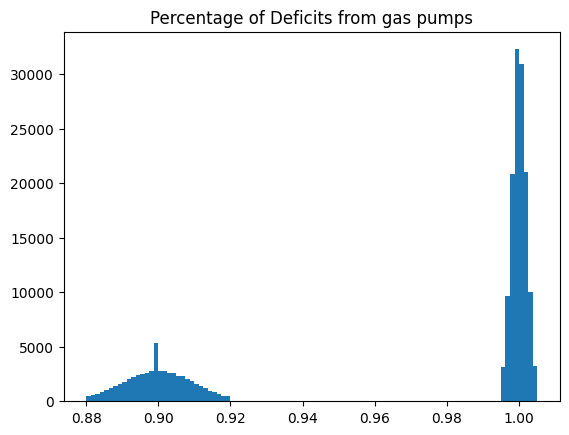

Mean: 0.9700163264149834
Std: 0.04609335219292462
Min: 0.8800090808064542
Max: 1.0049996681601108


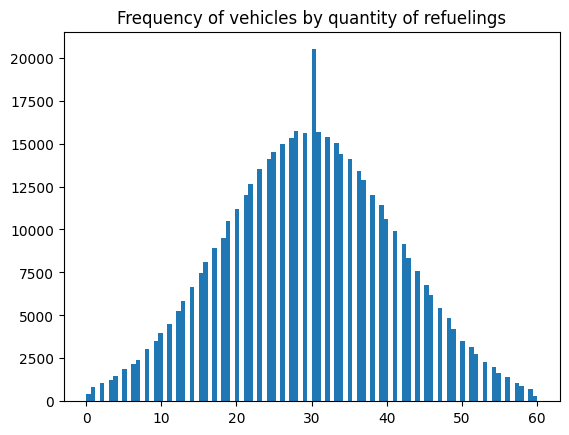

Mean: 29.690320877309343
Std: 11.32489123923211
Min: 0
Max: 60


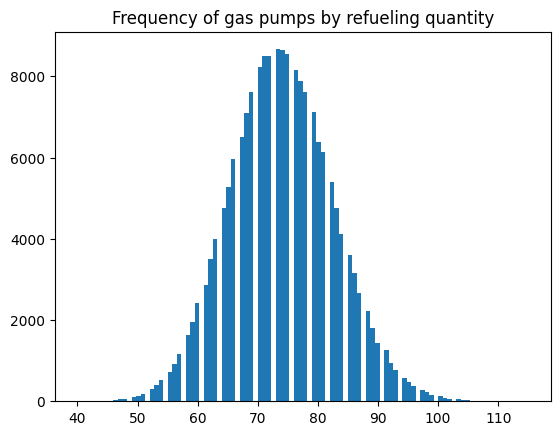

Mean: 73.85035157689043
Std: 8.594538293011016
Min: 40
Max: 115


In [ ]:
# Post-generation checks
#crossParametersCheckByProfile('automobilesWithGasoline', vehiclesByProfile['automobilesWithGasoline'], {'refuelingsVolumeList': groupedRefuelingsByFuel['gasoline']['refuelingsVolumeList'][0], 'refuelingsGasPumpList': groupedRefuelingsByFuel['gasoline']['refuelingsGasPumpList'][0]})
plotDistributions(gasPumpsByType['gasoline'], {'refuelingsVolumeList': groupedRefuelingsByFuel['gasoline']['refuelingsVolumeList'][0], 'refuelingsGasPumpList': groupedRefuelingsByFuel['gasoline']['refuelingsGasPumpList'][0]})

In [ ]:
gasPumpsDeficitList = generateGasPumps(519.192, 1 - peakShortfall/100, 1 - meanDeficit/100)
gasPumpsDeficitListPercent = twoPeaksDistribution(first=1, second=peakShortfall, range1=tolerance/100, range2=peakShortfallVariation/100, size=519.192, mean=3, std1=0.2, std2=1)


plotHistDistribution(gasPumpsDeficitList, '', bins=100)
plotHistDistribution(gasPumpsDeficitListPercent, '', bins=100)


# Conference Tests (checks if the simulation was generated correctly)

In [ ]:
# Test by profile
gasPumpsGasoline = generateGasPumps(gasPumpsByFuel['gasoline'], 1 - peakShortfall/100, 1 - meanDeficit/100)
vehicles1 = generateVehiclesList(profiles['automobilesWithGasoline'])
refuelings1 = generateRefuelingTable(profiles['automobilesWithGasoline'], 'gasoline', gasPumpsDeficitList=gasPumpsGasoline, vehiclesOdometerList=vehicles1, biasedVehiclesFault=biasedVehiclesFault, biasedVehiclesManipulation=biasedVehiclesManipulation, biasedFault=biasedFault, efficiencyBias=efficiencyBias)

vehicles2 = generateVehiclesList(profiles['lightCommercialGasoline'])
refuelings2 = generateRefuelingTable(profiles['lightCommercialGasoline'], 'gasoline', gasPumpsDeficitList=gasPumpsGasoline, vehiclesOdometerList=vehicles2, biasedVehiclesFault=biasedVehiclesFault, biasedVehiclesManipulation=biasedVehiclesManipulation, biasedFault=biasedFault, efficiencyBias=efficiencyBias)

vehicles3 = generateVehiclesList(profiles['motorcycleWithGasoline'])
refuelings3 = generateRefuelingTable(profiles['motorcycleWithGasoline'], 'gasoline', gasPumpsDeficitList=gasPumpsGasoline, vehiclesOdometerList=vehicles3, biasedVehiclesFault=biasedVehiclesFault, biasedVehiclesManipulation=biasedVehiclesManipulation, biasedFault=biasedFault, efficiencyBias=efficiencyBias)


In [ ]:

# Post-generation checks
#crossParametersCheckByProfile('automobilesWithGasoline', automobilesWithGasoline, {'refuelingsVolumeList': refuelingsAutomobilesWithGasoline['refuelingsVolumeList'], 'refuelingsGasPumpList': refuelingsAutomobilesWithGasoline['refuelingsGasPumpList']})
#plotDistributions(gasPumpsGasoline, {'refuelingsVolumeList': refuelingsAutomobilesWithGasoline['refuelingsVolumeList'], 'refuelingsGasPumpList': refuelingsAutomobilesWithGasoline['refuelingsGasPumpList']})

vehiclesRating1 = vehiclesEvaluation(refuelings1, vehicles1, profiles['automobilesWithGasoline'])
vehiclesRating2 = vehiclesEvaluation(refuelings2, vehicles2, profiles['lightCommercialGasoline'])
vehiclesRating3 = vehiclesEvaluation(refuelings3, vehicles3, profiles['motorcycleWithGasoline'])
#print(vehiclesRating)

#vehicles_ordered_ranking = sorted(vehiclesRating.items(), key=lambda item: item[1])
#print(vehicles_ordered_ranking)

#vehiclesEvaluationPlot = list(list(zip(*vehicles_ordered_ranking))[1])

#plt.plot([1 for i in range(len(vehiclesEvaluationPlot))],vehiclesEvaluationPlot, '.')
#plt.title('Vehicles evaluation')
#print('antes:', len(vehiclesEvaluationPlot))
#plotHistDistribution(vehiclesEvaluationPlot, 'Vehicles evaluation')

vehiclesOutliers1, vehiclesRating1 = removeOutliers(vehiclesRating1)
vehiclesOutliers2, vehiclesRating2 = removeOutliers(vehiclesRating2)
vehiclesOutliers3, vehiclesRating3 = removeOutliers(vehiclesRating3)

#print('outliers', vehiclesOutliers)
#vehicles_ordered_ranking_outliers = sorted(vehiclesOutliers.items(), key=lambda item: item[1])
#vehiclesOutliersPlot = list(list(zip(*vehicles_ordered_ranking_outliers))[1])
#print('outliers total:', len(vehiclesOutliersPlot))
#plotHistDistribution(vehiclesOutliersPlot, 'Vehicles outliers')

#print('vehicles', vehiclesRating)
vehicles_ordered_ranking1 = sorted(vehiclesRating1.items(), key=lambda item: item[1])
vehicles_ordered_ranking2 = sorted(vehiclesRating2.items(), key=lambda item: item[1])
vehicles_ordered_ranking3 = sorted(vehiclesRating3.items(), key=lambda item: item[1])
#vehiclesEvaluationPlot = list(list(zip(*vehicles_ordered_ranking))[1])
#print('final total:', len(vehiclesEvaluationPlot))
#plotHistDistribution(vehiclesEvaluationPlot, 'Vehicles evaluation 2')

matrixVehicles1 = generateConfusionMatrixVehiclesAnomaly(20, profiles['automobilesWithGasoline']['vehicles'], vehiclesOutliers1, vehiclesRating1, profile_name='automobilesWithGasoline', print_result=False)
matrixVehicles2 = generateConfusionMatrixVehiclesAnomaly(20, profiles['lightCommercialGasoline']['vehicles'], vehiclesOutliers2, vehiclesRating2, profile_name='lightCommercialGasoline', print_result=False)
matrixVehicles3 = generateConfusionMatrixVehiclesAnomaly(20, profiles['motorcycleWithGasoline']['vehicles'], vehiclesOutliers3, vehiclesRating3, profile_name='motorcycleWithGasoline', print_result=False)

joinMatrix([matrixVehicles1, matrixVehicles2, matrixVehicles3], 'Vehicles Outliers')

#generateConfusionMatrixVehiclesAnomaly(20, nVehicles, vehiclesOutliers3, vehiclesRating3, profile_name='motorcycleWithGasoline')

gasPumpsRating1 = gasPumpsEvaluation(refuelings1, 'gasoline', vehiclesRating1)
gasPumpsRating2 = gasPumpsEvaluation(refuelings2, 'gasoline', vehiclesRating2)
gasPumpsRating3 = gasPumpsEvaluation(refuelings3, 'gasoline', vehiclesRating3)

gas_pumps_ordered_ranking1 = sorted(gasPumpsRating1.items(), key=lambda item: item[1])
gas_pumps_ordered_ranking2 = sorted(gasPumpsRating2.items(), key=lambda item: item[1])
gas_pumps_ordered_ranking3 = sorted(gasPumpsRating3.items(), key=lambda item: item[1])
#print(gas_pumps_ordered_ranking)
#gasPumpsRankingPlot = list(list(zip(*gas_pumps_ordered_ranking))[1])
#plotHistDistribution(gasPumpsRankingPlot, 'Gas pumps ranking')

matrixGasPumps1 = generateConfusionMatrixGasPumps(30, gasPumpsDeficitList=gasPumpsGasoline, ranking=gas_pumps_ordered_ranking1, positivity=positivity, name='gasoline 1', print_result=True)
matrixGasPumps2 = generateConfusionMatrixGasPumps(30, gasPumpsDeficitList=gasPumpsGasoline, ranking=gas_pumps_ordered_ranking2, positivity=positivity, name='gasoline 2', print_result=True)
matrixGasPumps3 = generateConfusionMatrixGasPumps(30, gasPumpsDeficitList=gasPumpsGasoline, ranking=gas_pumps_ordered_ranking3, positivity=positivity, name='gasoline 3', print_result=True)


In [ ]:
# profile test using grouping function
groupedVehiclesByFuel_ = {'gasoline': [vehiclesRating1, vehiclesRating2, vehiclesRating3]}
groupedRefuelingsByFuel_ = {'gasoline': {'refuelingsGasPumpList': [], 'refuelingsVolumeList': []}}

groupedRefuelingsByFuel_['gasoline']['refuelingsGasPumpList'].append(refuelings1['refuelingsGasPumpList'])
groupedRefuelingsByFuel_['gasoline']['refuelingsVolumeList'].append(refuelings1['refuelingsVolumeList'])

groupedRefuelingsByFuel_['gasoline']['refuelingsGasPumpList'].append(refuelings2['refuelingsGasPumpList'])
groupedRefuelingsByFuel_['gasoline']['refuelingsVolumeList'].append(refuelings2['refuelingsVolumeList'])

groupedRefuelingsByFuel_['gasoline']['refuelingsGasPumpList'].append(refuelings3['refuelingsGasPumpList'])
groupedRefuelingsByFuel_['gasoline']['refuelingsVolumeList'].append(refuelings3['refuelingsVolumeList'])

gasPumpsRating = gasPumpsEvaluationGrouped(groupedRefuelingsByFuel_['gasoline'], 'gasoline', groupedVehiclesByFuel_['gasoline'])

gas_pumps_ordered_ranking = sorted(gasPumpsRating.items(), key=lambda item: item[1])
#print(gas_pumps_ordered_ranking)
gasPumpsRankingPlot = list(list(zip(*gas_pumps_ordered_ranking))[1])
#plotHistDistribution(gasPumpsRankingPlot, 'Gas pumps ranking')

matrixGasPumps = generateConfusionMatrixGasPumps(30, gasPumpsDeficitList=gasPumpsGasoline, ranking=gas_pumps_ordered_ranking, positivity=positivity, name='Gas pumps gasoline', print_result=True)
